In [88]:
import sys
sys.path.insert(0, "../kitti/")

from math import sqrt
import os
import glob
import numpy as np
from iou_3d import get_3d_box, box3d_iou
from collections import namedtuple
from util_kitti import KITTI_Object

from ap_critical import cal_criticality

AP_MODE = "my" # 'critical'


CALIB_PATH = "/home/lab530/KenYu/kitti/training/calib/"
# Input : Label and Prediction in standard format
# Output : Graph, picture, data......

INPUT_LABEL = "/home/lab530/KenYu/kitti/training/label_2/"

# DD3D
INPUT_PRIDT = "/home/lab530/KenYu/ml_toolkit/3d_object_detection_visualization/dd3d_prediction/"
# GAC
# INPUT_PRIDT = "/home/lab530/KenYu/visualDet3D/exp_output/best/Mono3D/output/validation/data/" # "/home/lab530/KenYu/visualDet3D/baseline_exp/Mono3D/output/validation/data/"
# Monoflex
# INPUT_PRIDT = "/home/lab530/KenYu/ml_toolkit/3d_object_detection_visualization/monoflex_prediction/"
# Psudeo lidar
# INPUT_PRIDT = "/home/lab530/KenYu/ml_toolkit/3d_object_detection_visualization/pseudo_lidar_prediction/"

# TODO maybe we should do AP evaluation here to unify metric
# TODO don't care don't count as fp 
# TODO truck and car don't count as fp 
# TODO Different Threshold setting 
# TODO use GAC evaluation instead of creating of my own
THRES = {"easy" : {"min_height": 40, "max_occlusion": 0, "max_truncation": 0.15}, 
         "modt" : {"min_height": 25, "max_occlusion": 1, "max_truncation": 0.3}, 
         "hard" : {"min_height": 25, "max_occlusion": 2, "max_truncation": 0.5},}

N_PRIDT = len(os.listdir(INPUT_PRIDT))

Match = namedtuple('Match', ['idx', 'iou', 'conf'])
class Object(KITTI_Object):
    def __init__        (self, str_line, tf_matrix, idx_img = None, idx_line = None, center_2d = None, ap_mode="critical"):
        super().__init__(str_line, tf_matrix, idx_img = None, idx_line = None, center_2d = None)
        
        self.len_min_edge = min(self.xmax - self.xmin, self.ymax - self.ymin)
        self.center_2d = ( (self.xmax + self.xmin)/2.0, (self.ymax + self.ymin)/2.0 )
        self.x_offset_from_pincipal_axis = abs(self.x3d)
        self.euclidean_depth = sqrt((self.x3d**2 + self.y3d**2 + self.z3d**2))
        self.match = {'bev': [], '3db': []} # [(idx, iou, conf), (idx, iou, conf)]
        
        self.kappa = cal_criticality( np.array( [[self.x3d, self.z3d, self.rot_y]] ), ap_mode=AP_MODE) [0]

# Visualize AP_criti and AP_sct

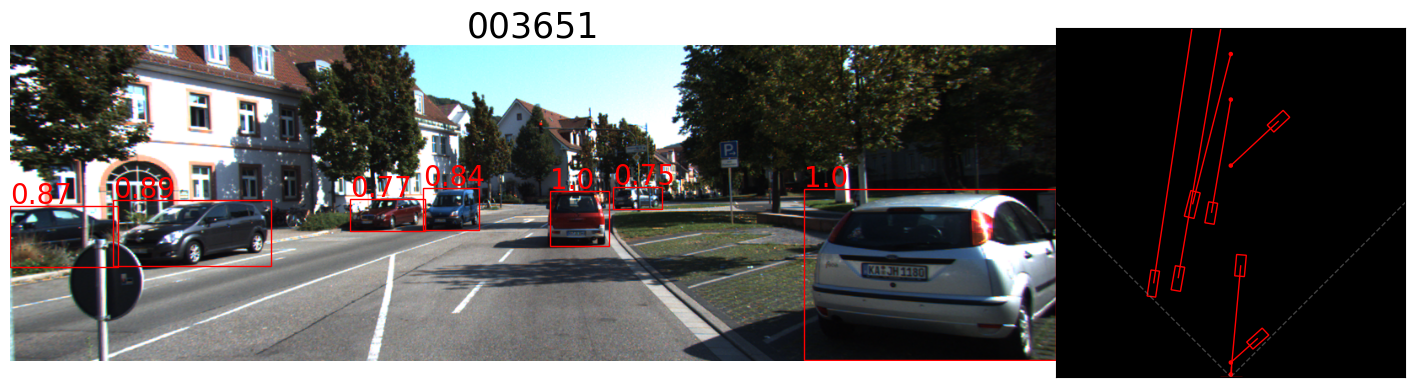

In [89]:

import cv2
import os
import sys
sys.path.insert(0, "../kitti/")
from util_kitti import init_img_plt, draw_2Dbox, xz2bev, draw_birdeyes, kitti_calib_file_parser
import random 
import matplotlib.pyplot as plt 
from matplotlib.path import Path
import matplotlib.patches as patches
from matplotlib.patches import PathPatch
import numpy as np
from matplotlib.colors import hsv_to_rgb

NUM_IMAGE_SHOW = 30

# images files 
IMG_DIR = "/home/lab530/KenYu/kitti/training/image_2/"
# Anotations files 
ANO_DIR = "/home/lab530/KenYu/kitti/training/label_2/"
# Prediction files
PRD_DIR = "/home/lab530/KenYu/visualDet3D/exp_output/loss/Mono3D/output/validation/data/"
# 
CAR_DIR = "/home/lab530/KenYu/kitti/training/calib/"

random.seed(123)
img_names = [i.split('.')[0] for i in os.listdir(ANO_DIR)]

random.shuffle(img_names)

chose_name = img_names[:NUM_IMAGE_SHOW]

# chose_name = ['003308', '000712', '007360', '003993', '001718', '000039', '006050', '000249', '005191', '000631', '006090']
chose_name = ['007008', '003870', '004934', '007166', '001789', '007407', '006831', '001303', '006655', '006733', '003378', '005833', '003651']
# chose_name = ['003651']

# Transform image 
chose_img = []
chose_P2  = []
for name in chose_name:
    P2 = kitti_calib_file_parser(os.path.join(CAR_DIR, f"{name}.txt"))
    img = cv2.imread(os.path.join(IMG_DIR, f"{name}.png"))
    
    chose_P2.append(P2)
    chose_img.append(img)

axs = init_img_plt(chose_img, titles = chose_name)

for i, img_name in enumerate(chose_name):
    
    with open(os.path.join(ANO_DIR, f"{img_name}.txt")) as f:
        lines = f.read().splitlines()
        lines = list(lines for lines in lines if lines) # Delete empty lines
    objs = [Object(str_line + " NA",
                    idx_img = img_name,
                    idx_line = idx_line, 
                    tf_matrix = chose_P2[i],
                    ap_mode=AP_MODE) for idx_line, str_line in enumerate(lines)]
        
    # Filter Non-car Objs
    objs = [obj for obj in objs if obj.category == "Car"]

    
    # Calculate criticality
    xzyaw = np.concatenate( [np.array([obj.x3d   for obj in objs])[..., np.newaxis], 
                             np.array([obj.z3d   for obj in objs])[..., np.newaxis],
                             np.array([obj.rot_y for obj in objs])[..., np.newaxis]], axis=1) 
    
    kappas = cal_criticality(xzyaw, ap_mode="my")
    # kappas = np.ones_like(kappas) # For drawing original 
    # print(kappas.shape)

    p_cz = xzyaw[:, 1] - xzyaw[:, 0]*np.tan(-xzyaw[:, 2]) # z value of point of collision
    # print(p_cz.shape)
    
    for i_obj in range(len(objs)):
        
        # color = [random.uniform(0.5, 1) for _ in range(3)]
        
        # # Generate random hue values between 0 and 1
        # hues = np.random.rand(1)

        # # Set saturation and brightness to maximum values (1)
        # s = 1
        # v = 0.8

        # # Create an array of colors in HSV format
        # colors_hsv = np.column_stack((hues, s * np.ones_like(hues), v * np.ones_like(hues)))

        # # Convert the HSV colors to RGB colors
        # color = hsv_to_rgb(colors_hsv) [0]
        color = [1, 0, 0]
        
        # Draw collision line on BEV image
        path = Path(np.array([xz2bev(objs[i_obj].x3d, objs[i_obj].z3d), 
                              xz2bev(0, p_cz[i_obj])], float), [Path.MOVETO, Path.LINETO])
        pathpatch = PathPatch(path, fill=False, color=color, linewidth=1)
        axs[i][1].add_patch(pathpatch)
        
        # Draw collision point on BEV image
        endpoint = patches.Circle(xz2bev(0, p_cz[i_obj]), radius=4, color=color)
        axs[i][1].add_patch(endpoint)
        
        # Write Criticality on image
        axs[i][0].text(objs[i_obj].xmin, objs[i_obj].ymin-3, f'{round(kappas[i_obj], 2)}', fontsize = 20, color = color)
        
        # Draw bbox
        draw_2Dbox   (axs[i][0], (objs[i_obj].xmin, objs[i_obj].ymin, objs[i_obj].xmax, objs[i_obj].ymax), color = color)
        draw_birdeyes(axs[i][1], objs[i_obj], color = color, title = "123", is_print_confident = False)
    

# Draw the sigmoid function

Text(0.5, 1.0, 'Sigmoid function')

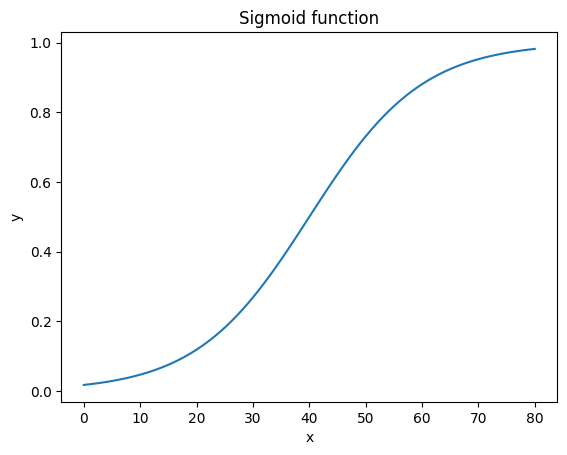

In [90]:
raise NotImplementedError

from ap_critical import sigmoid
# generate x-values
x = np.linspace(0, 80, 100)

# compute y-values using sigmoid function
y = sigmoid(x, offset=40, steep=0.1)

# plot sigmoid curve
plt.plot(x, y)

# set axis labels and title
plt.xlabel('x')
plt.ylabel('y')
plt.title('Sigmoid function')

# # show plot
# plt.show()

## Find IOU

In [91]:
# raise NotImplementedError

gts_all = []
pds_all = []
all_conf_thres = set()
for idx_path, path in enumerate(glob.glob(INPUT_PRIDT + "*.txt")):
    fn = path.split("/")[-1] # 003322.txt
    # if fn != "001051.txt" : continue
    
    # 
    P2 = kitti_calib_file_parser(CALIB_PATH + fn)

    # Load ground true label
    with open(INPUT_LABEL + fn, "r") as f:
        lines = f.read().splitlines()
        lines = list(lines for lines in lines if lines) # Delete empty lines
    gts =  [Object(str_line + " NA",
                   idx_img = fn,
                   idx_line = idx_line, 
                   tf_matrix = P2) for idx_line, str_line in enumerate(lines)]

    # Load prediction
    with open(INPUT_PRIDT + fn, "r") as f:
        lines = f.read().splitlines()
        lines = list(lines for lines in lines if lines) # Delete empty lines
    pds =  [Object(str_line,
                   idx_img = fn,
                   idx_line = idx_line, 
                   tf_matrix = P2) for idx_line, str_line in enumerate(lines)]

    # Delete unwanted category
    gts = [gt for gt in gts if gt.category == "Car"]
    pds = [pd for pd in pds if pd.category == "Car"]
    # print(f"Number of ground trues: {len(gts)}")
    # print(f"Number of predictions: {len(pds)}")

    # Sort prediction by confident score
    pds = sorted(pds, key=lambda x: x.score, reverse=True)
    
    # Find max iou ground true match with prediction
    for pd_idx, pd in enumerate(pds):
        best_bev = (None, 0.0) # (gt_idx, iou)
        best_3db = (None, 0.0) # (gt_idx, iou)
        for gt_idx, gt in enumerate(gts):
            gt_corners = get_3d_box((gt.l, gt.w, gt.h), gt.rot_y, (gt.x3d, gt.y3d, gt.z3d))
            pd_corners = get_3d_box((pd.l, pd.w, pd.h), pd.rot_y, (pd.x3d, pd.y3d, pd.z3d))
            iou_3db, iou_bev = box3d_iou(gt_corners, pd_corners)
            if iou_bev > best_bev[1]:
                best_bev = (gt_idx, iou_bev)
            if iou_3db > best_3db[1]:
                best_3db = (gt_idx, iou_3db)
        
        # BEV
        if best_bev[0] != None:
            pds[pd_idx     ].match['bev'].append( Match(best_bev[0], best_bev[1], pd.score) )
            gts[best_bev[0]].match['bev'].append( Match(pd_idx,      best_bev[1], pd.score) )
        
        # 3DB
        if best_3db[0] != None:
            pds[pd_idx     ].match['3db'].append( Match(best_3db[0], best_3db[1], pd.score) )
            gts[best_3db[0]].match['3db'].append( Match(pd_idx,      best_3db[1], pd.score) )
        
        # Confident threshold
        all_conf_thres.add(pd.score)

    gts_all.extend(gts)
    pds_all.extend(pds)
    
    # Print progress
    if (idx_path+1) % 500 == 0:
        print(f"Processed {idx_path+1}/{N_PRIDT}")

# Confident threshold

all_conf_thres = sorted(list(all_conf_thres), reverse=False)
print(f"Number of total ground true: {len(gts_all)}")
print(f"Number of total detections: {len(pds_all)}")
print(f"Number of total different confident: {len(all_conf_thres)}")


Processed 500/3765
Processed 1000/3765
Processed 1500/3765
Processed 2000/3765
Processed 2500/3765
Processed 3000/3765
Processed 3500/3765
Number of total ground true: 14385
Number of total detections: 58925
Number of total different confident: 58841


## Calculate AP

In [92]:
from collections import defaultdict

MAX_N_CONF_THRES = 2000
# IOU_THRES_NAME = ['AP_50', 'AP_55', 'AP_60', 'AP_65', 'AP_70', 'AP_75', 'AP_80', 'AP_85', 'AP_90', 'AP_95']
# IOU_THRES      = [round(int(i.split("_")[-1])/100, 2) for i in IOU_THRES_NAME]
IOU_THRES_NAME = ['AP_50', 'AP_70']
IOU_THRES      = [0.5    , 0.7    ]
rp = {'bev': defaultdict(list),
      '3db': defaultdict(list),
      'bev_crit': defaultdict(list),
      '3db_crit': defaultdict(list),} # [{'AP_50': [(recall, precision), (), .....], 'AP_55', .....}]

# Reduce number of total confident score in order to save time
print(f"Number of different confident: {len(all_conf_thres)}")
if len(all_conf_thres) > MAX_N_CONF_THRES:
    new_idx = np.round(np.linspace(0, len(all_conf_thres) - 1, MAX_N_CONF_THRES)).astype(int)
    all_conf_thres = [all_conf_thres[new_i] for new_i in new_idx]
all_conf_thres = [0] + all_conf_thres + [1.0]
#
print(f"Number of total groundtrue: {len(gts_all)}")
print(f"Number of total prediction: {len(pds_all)}")
print(f"Number of reduced confidents: {len(all_conf_thres)}")
# 
for type in ['bev', '3db']:
    for iou_idx, iou_thres in enumerate(IOU_THRES):
        for conf_thres in all_conf_thres: # enumerate(np.arange(0, 1+1/N_CONF_THRES, 1/N_CONF_THRES)) :
            # Get tp, fn ,fp 
            tp, fn, fp = 0, 0, 0
            tp_gt_crit, tp_pd_crit, fn_gt_crit, fp_pd_crit = 0, 0, 0, 0
            for gt in gts_all:
                is_find = False
                for match in gt.match[type]:
                    if match.conf > conf_thres:
                        if is_find is False and match.iou > iou_thres:
                            tp += 1
                            tp_gt_crit += gt.kappa
                            tp_pd_crit += pds_all[match[0]].kappa
                            is_find = True # One ground true could only have one positive
                        else:
                            fp += 1
                            fp_pd_crit += pds_all[match[0]].kappa
                if not is_find:
                    fn += 1
                    fn_gt_crit += gt.kappa
            
            # Recall and Precision 
            try:
                rp[type][IOU_THRES_NAME[iou_idx]].append( (tp/(tp+fn), tp/(tp+fp)) )
            except ZeroDivisionError:
                pass
            try:
                percision_safe = tp_pd_crit / (tp_pd_crit + fp_pd_crit)
                recall_safe    = tp_gt_crit / (tp_gt_crit + fn_gt_crit)
                # print(f"(p, r) = {(tp/(tp+fn), tp/(tp+fp))}")
                # print(f"(percision_safe, recall_safe) = {(percision_safe, recall_safe)}")
                rp[type+"_crit"][IOU_THRES_NAME[iou_idx]].append( (recall_safe, percision_safe) )
            except ZeroDivisionError:
                pass
            # print(f"(tp, fn, fp) = {(tp, fn, fp)}")
            assert tp + fn == len(gts_all), "Something weird happned, tp + fn != number of ground true !!"

        rp[type][IOU_THRES_NAME[iou_idx]] = sorted(rp[type][IOU_THRES_NAME[iou_idx]], key=lambda x: x[0])
        print(f"Finish Calculate {type} RP_Curve under IOU = {iou_thres}")
        rp[type+"_crit"][IOU_THRES_NAME[iou_idx]] = sorted(rp[type+"_crit"][IOU_THRES_NAME[iou_idx]], key=lambda x: x[0])
        print(f"Finish Calculate {type}_crit RP_Curve under IOU = {iou_thres}")
    print(f"Number of rp point = {len(rp[type]['AP_50'])}")


Number of different confident: 58841
Number of total groundtrue: 14385
Number of total prediction: 58925
Number of reduced confidents: 2002
Finish Calculate bev RP_Curve under IOU = 0.5
Finish Calculate bev_crit RP_Curve under IOU = 0.5
Finish Calculate bev RP_Curve under IOU = 0.7
Finish Calculate bev_crit RP_Curve under IOU = 0.7
Number of rp point = 2000
Finish Calculate 3db RP_Curve under IOU = 0.5
Finish Calculate 3db_crit RP_Curve under IOU = 0.5
Finish Calculate 3db RP_Curve under IOU = 0.7
Finish Calculate 3db_crit RP_Curve under IOU = 0.7
Number of rp point = 2000


## Plot AP

rp['bev_crit'][AP_50]=  [(0.002294393974811296, 0.9655172413793104), (0.004414459229952523, 0.9642857142857142), (0.006705481891697877, 0.9647058823529412), (0.008981369256977885, 0.9649068268470946), (0.011159943874652774, 0.9580367590546467), (0.013253912483832108, 0.9476528505808689), (0.015601343291435142, 0.9552041383030483), (0.01769868568715163, 0.9519464769515902), (0.019967456902190834, 0.9534692005163281), (0.02184536195708195, 0.9405373393862898), (0.024057883116665985, 0.9366698034601132), (0.026265781033240378, 0.9361925635409264), (0.02837974355266688, 0.930617497174178), (0.03042625618747128, 0.9302868111434281), (0.032763622549717396, 0.932793195963527), (0.03500523070400947, 0.934702130741243), (0.03694095615185159, 0.9303384200055593), (0.03914486297312637, 0.9285958844328824), (0.04118294522967432, 0.9234226983332481), (0.04327678310489435, 0.9236686904465684), (0.04545017494022544, 0.925539155696291), (0.04755584308780312, 0.922763557564259), (0.04963984661779208, 0

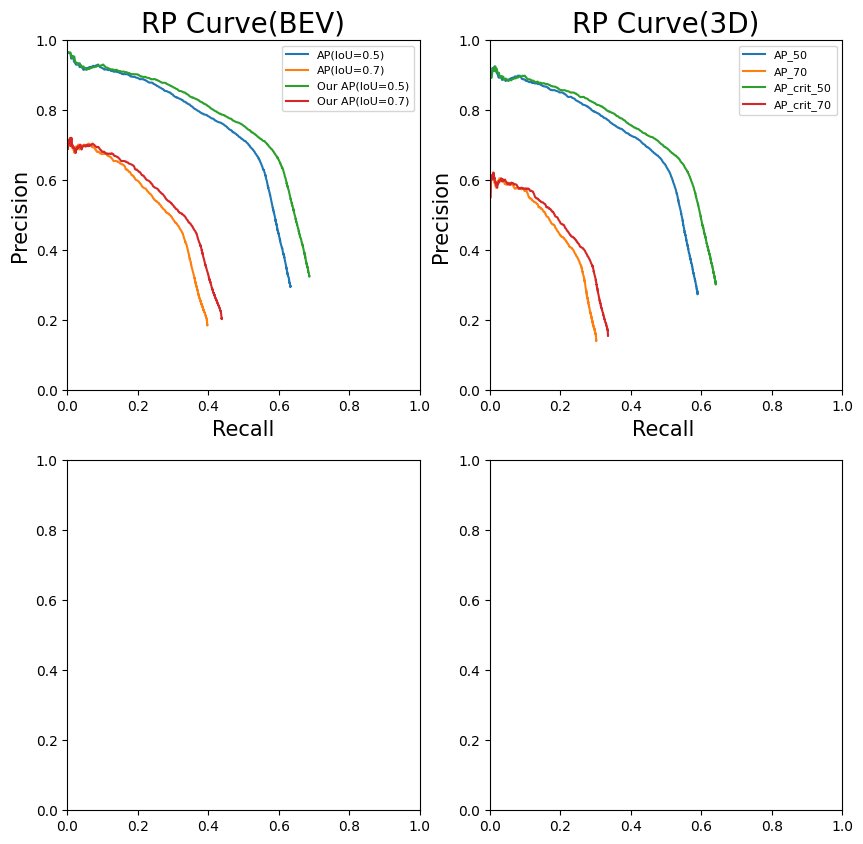

In [93]:
# 11-point scheme, recall = [0, 0.1, 0.2, ... 1.0] # Use by KITTI, before  08.10.2019
# 40-point scheme, recall = [1/40, 2/40, 3/40, .... 40/40] # KITTI improved version (Suggested by MonoDIS)

print(f"rp['bev_crit'][AP_50]=  {rp['bev_crit']['AP_50']}")

for type in rp.keys():
    print(f"============ {type} evaluation ============")
    for ap_name in rp[type]:
        ap = 0
        for recall in np.arange(1/40, 41/40, 1/40): # 40-point scheme
            for rp_point in rp[type][ap_name]:
                if rp_point[0] >= recall:
                    ap += rp_point[1] / 40
                    # print(f"sample AP curve point : {rp_point}")
                    break
        print(f"{ap_name} = {round(ap, 4)}")

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
fig.set_facecolor('white')

# plotting the points
ax_cur = ax[0, 0]
#
ax_cur.plot([i[0] for i in rp['bev']["AP_50"] ], [i[1] for i in rp['bev']["AP_50"] ], label='AP(IoU=0.5)',) # color=(76/255, 153/255 , 0.0))
ax_cur.plot([i[0] for i in rp['bev']["AP_70"] ], [i[1] for i in rp['bev']["AP_70"] ], label='AP(IoU=0.7)',) # color=(0/255, 255/255 , 0.0))# color=(51/255, 255/255 , 51/255))
ax_cur.plot([i[0] for i in rp['bev_crit']["AP_50"] ], [i[1] for i in rp['bev_crit']["AP_50"] ], label='Our AP(IoU=0.5)')
ax_cur.plot([i[0] for i in rp['bev_crit']["AP_70"] ], [i[1] for i in rp['bev_crit']["AP_70"] ], label='Our AP(IoU=0.7)')
ax_cur.set_xlim([0, 1.0])
ax_cur.set_ylim([0, 1.0])
ax_cur.set_xlabel('Recall',    fontsize=15)
ax_cur.set_ylabel('Precision', fontsize=15)
ax_cur.set_title('RP Curve(BEV)', fontsize=20)
ax_cur.legend(fontsize=8)
#
ax_cur = ax[0, 1]
ax_cur.plot([i[0] for i in rp['3db']["AP_50"] ], [i[1] for i in rp['3db']["AP_50"] ], label='AP_50')
ax_cur.plot([i[0] for i in rp['3db']["AP_70"] ], [i[1] for i in rp['3db']["AP_70"] ], label='AP_70')
ax_cur.plot([i[0] for i in rp['3db_crit']["AP_50"] ], [i[1] for i in rp['3db_crit']["AP_50"] ], label='AP_crit_50')
ax_cur.plot([i[0] for i in rp['3db_crit']["AP_70"] ], [i[1] for i in rp['3db_crit']["AP_70"] ], label='AP_crit_70')
ax_cur.set_xlim([0, 1.0])
ax_cur.set_ylim([0, 1.0])
ax_cur.set_xlabel('Recall ', fontsize=15)
ax_cur.set_ylabel('Precision ', fontsize=15)
ax_cur.set_title('RP Curve(3D)', fontsize=20)
ax_cur.legend(fontsize=8)

## Calcuate AR rate

In [94]:
x3d_bucket = np.array([-40, -30, -20, -10, 0, 10, 20, 30, 40]) # m
x3d_values = [{'tp':0, 'fn':0, 'fp':0} for _ in range(len(x3d_bucket))]
# 
z3d_bucket = np.array([5, 15, 25, 35, 45, 55, 65, 75]) # m
z3d_values = [{'tp':0, 'fn':0, 'fp':0} for _ in range(len(z3d_bucket))]
# 
area_bucket = np.array([100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]) # pixel
area_values = [{'tp':0, 'fn':0, 'fp':0} for _ in range(len(area_bucket))]

for gt in gts_all:
    # TODO maybe i should check whether there's candidate predication that has higher IOU
    # Leads to confidence error
    if len(gt.match['bev']) != 0 and gt.match['bev'][0][1] > IOU_THRES[0]: # Positive
        x3d_values[(np.abs(x3d_bucket - gt.x3d)).argmin()]['tp'] += 1
        z3d_values[(np.abs(z3d_bucket - gt.z3d)).argmin()]['tp'] += 1
        area_values[(np.abs(area_bucket - gt.area)).argmin()]['tp'] += 1
    else:
        x3d_values[(np.abs(x3d_bucket - gt.x3d)).argmin()]['fn'] += 1
        z3d_values[(np.abs(z3d_bucket - gt.z3d)).argmin()]['fn'] += 1
        area_values[(np.abs(area_bucket - gt.area)).argmin()]['fn'] += 1

x3d_values = [d['tp']/(d['tp'] + d['fn']) if d['tp'] + d['fn'] != 0 else 0 for d in x3d_values]
z3d_values = [d['tp']/(d['tp'] + d['fn']) if d['tp'] + d['fn'] != 0 else 0 for d in z3d_values]
area_values = [d['tp']/(d['tp'] + d['fn']) if d['tp'] + d['fn'] != 0 else 0 for d in area_values]

print("x_3d")
print(x3d_bucket)
print(x3d_values)
print("z_3d")
print(z3d_bucket)
print(z3d_values)
print("area_values")
print(area_bucket)
print(area_values)


x_3d
[-40 -30 -20 -10   0  10  20  30  40]
[0.0, 0.1702127659574468, 0.28097731239092494, 0.4750785810507409, 0.6928179614746779, 0.36758563074352546, 0.1452991452991453, 0.10810810810810811, 0]
z_3d
[ 5 15 25 35 45 55 65 75]
[0.8767441860465116, 0.7435757244395844, 0.5523690773067331, 0.42556701030927835, 0.3602216748768473, 0.17586649550706032, 0.125, 0.09826589595375723]
area_values
[ 100  200  300  400  500  600  700  800  900 1000]
[0.0, 0.22666666666666666, 0.13740458015267176, 0.1270718232044199, 0.13448275862068965, 0.22996515679442509, 0.44768856447688565, 0.3778409090909091, 0.3, 0.617234955859723]


## Draw plot

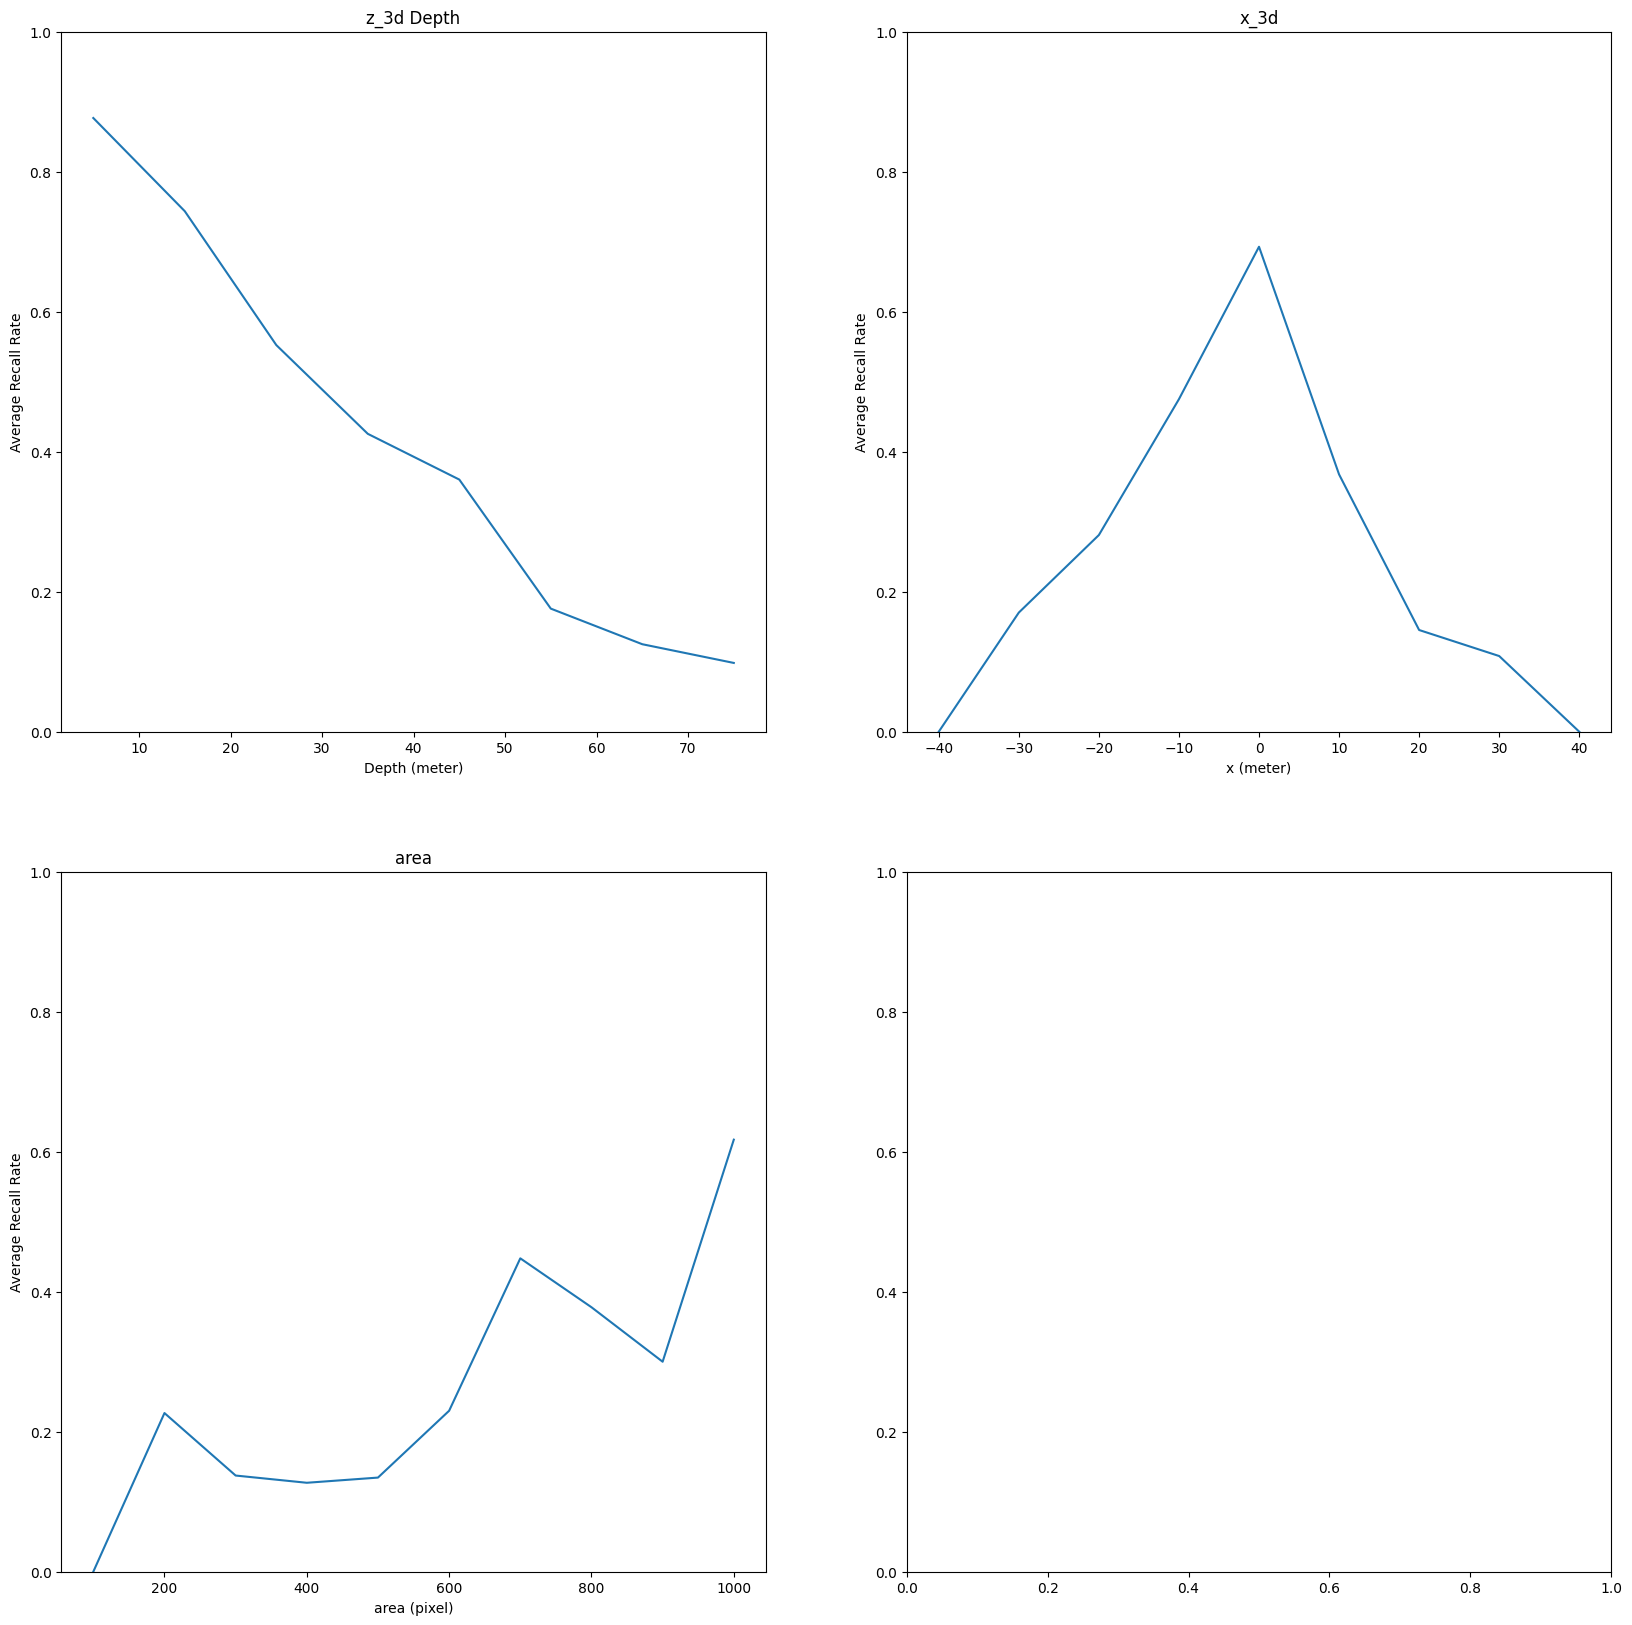

In [95]:


fig, ax = plt.subplots(2, 2, figsize=(20, 20))
fig.set_facecolor('white')
# plotting the points 
ax[0, 0].plot(z3d_bucket, z3d_values)
ax[0, 0].set_ylim([0, 1.0])
ax[0, 0].set_xlabel('Depth (meter)')
ax[0, 0].set_ylabel('Average Recall Rate')
ax[0, 0].set_title('z_3d Depth')
# 
ax[0, 1].plot(x3d_bucket, x3d_values)
ax[0, 1].set_ylim([0, 1.0])
ax[0, 1].set_xlabel('x (meter)')
ax[0, 1].set_ylabel('Average Recall Rate')
ax[0, 1].set_title('x_3d')
# 
ax[1, 0].plot(area_bucket, area_values)
ax[1, 0].set_ylim([0, 1.0])
ax[1, 0].set_xlabel('area (pixel)')
ax[1, 0].set_ylabel('Average Recall Rate')
ax[1, 0].set_title('area')
plt.show()

## Heatmap


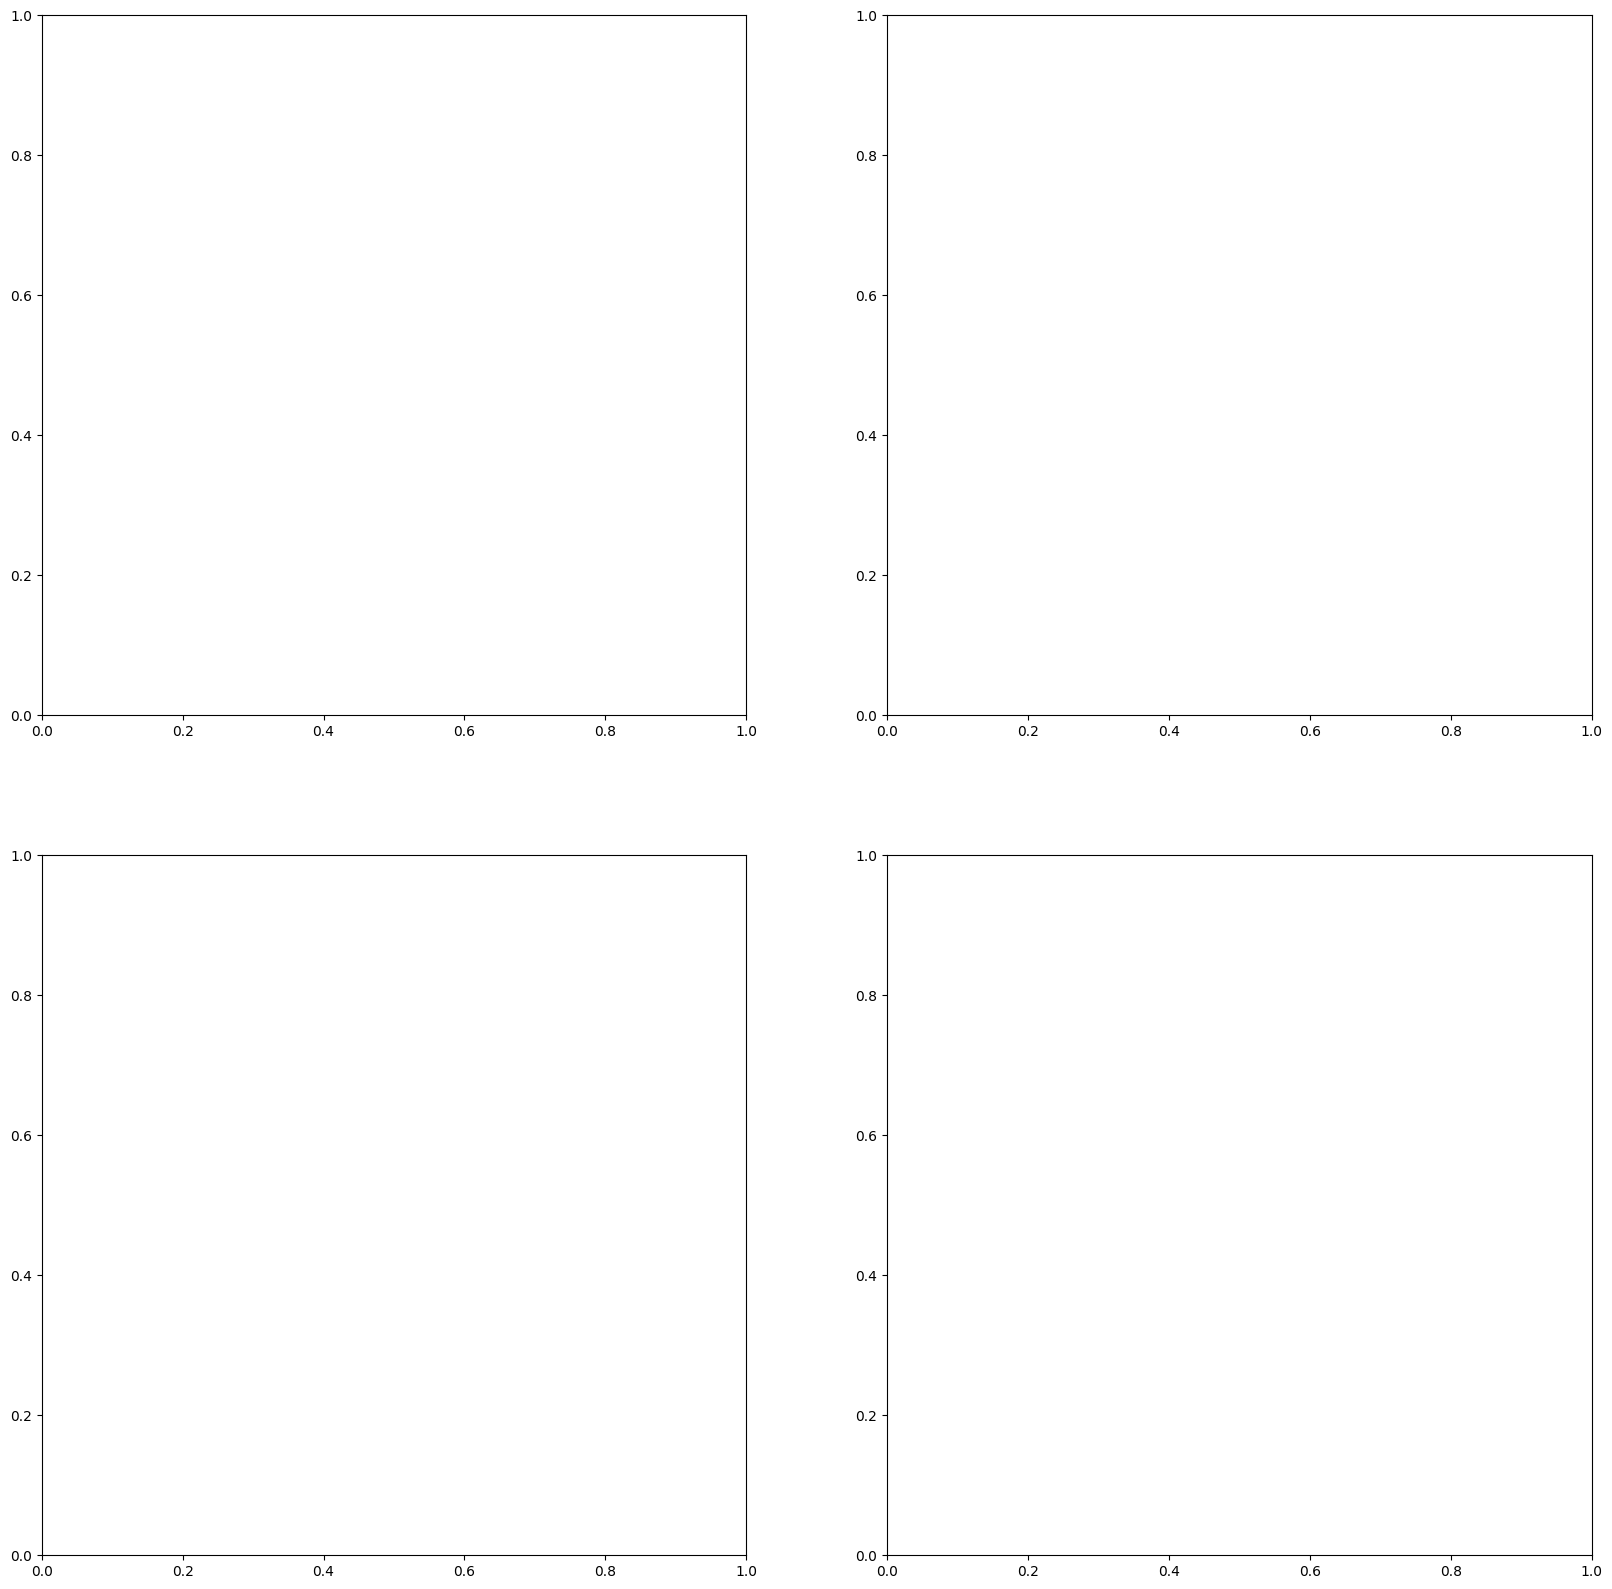

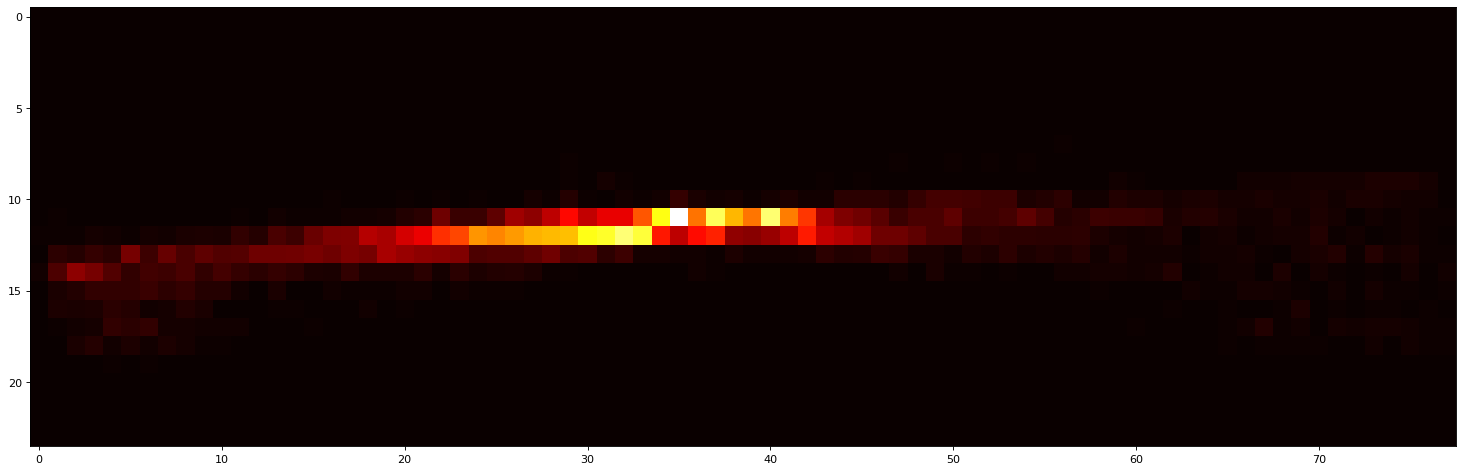

In [96]:
import matplotlib.pyplot as plt
import numpy as np
# 1242 x 375
DOWNSAMPLE_RATIO = 16
N_ROW =  375//DOWNSAMPLE_RATIO + 1
N_COL = 1242//DOWNSAMPLE_RATIO + 1

heat_data = np.zeros(shape=(N_ROW, N_COL))
for gt in gts_all:
    x, y = gt.center_2d

    # Output False negatives
    if len(gt.match['bev']) != 0 and gt.match['bev'][0][1] > IOU_THRES[0]: # Positive
        pass 
    else:
        # print((y//DOWNSAMPLE_RATIO, x//DOWNSAMPLE_RATIO))
        heat_data[int(y//DOWNSAMPLE_RATIO), int(x//DOWNSAMPLE_RATIO)] += 1 # 'fn'

fig, ax = plt.subplots(2, 2, figsize=(20, 20))
fig.set_facecolor('white')

plt.figure(figsize=(375//DOWNSAMPLE_RATIO, 1242//DOWNSAMPLE_RATIO), dpi=80)
plt.imshow(heat_data, cmap='hot', interpolation='nearest')
# ax[0, 0] = imshow(heat_data, cmap='hot', interpolation='nearest')
# cax = plt.axes([0.85, 0.1, 0.075, 0.8])
# plt.colorbar(cax=cax)
plt.show()
